In [1]:
import numpy as np
import pandas as pd
import os
import sys
import functools
from functools import partial
import torch
import torch.nn as nn
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList
import yaml
import optuna
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')
warnings.filterwarnings('ignore')
from stable_baselines3 import PPO
# from custom_env_folder.custom_env_ewma import Uniswapv3Env, CustomMLPFeatureExtractor
from custom_env_folder.custom_env import Uniswapv3Env, CustomMLPFeatureExtractor

## Benchmark LP

We want to test our RL based LP agent against a fixed behavior. Here, our benchmark only adjusts the price interval every 500 timesteps regardless of the environment.

In [2]:
# create directory
base_dir = os.getcwd()
output_dir = os.path.join(base_dir, "output")
config_dir = os.path.join(base_dir, "config")
plot_dir = os.path.join(base_dir, "plot")
data_dir = os.path.join(base_dir, "data")

dirs = [output_dir, config_dir, plot_dir, data_dir]
for dir in dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)  

# Load hyperparam file
with open(os.path.join(config_dir, "uniswap_rl_param.yaml"), "r") as f:
    params = yaml.safe_load(f)
    
data_dir = os.path.join(base_dir, "data")
# import market data
uni_table = pd.read_csv(params['filename'])

uni_time = uni_table[['timestamp']]
uni_data = uni_table[['price']]

split_size = 1500
dfs_list = [uni_data.iloc[i:i + split_size].reset_index(drop=True) for i in range(0, len(uni_data), split_size)]
dfs_list.pop()      # drop the last df which has different length

times_list = [uni_time.iloc[i:i + split_size].reset_index(drop=True) for i in range(0, len(uni_time), split_size)]
times_list.pop()    # drop the last df which has different length

gas_fee = 15
seed = params['seed']
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

expname = "20241122_PPOUniswap_Benchmark" 

ROLLING WINDOW: 0
ROLLING WINDOW: 1
ROLLING WINDOW: 2
ROLLING WINDOW: 3
ROLLING WINDOW: 4
ROLLING WINDOW: 5
ROLLING WINDOW: 6
ROLLING WINDOW: 7
ROLLING WINDOW: 8
ROLLING WINDOW: 9
ROLLING WINDOW: 10
ROLLING WINDOW: 11


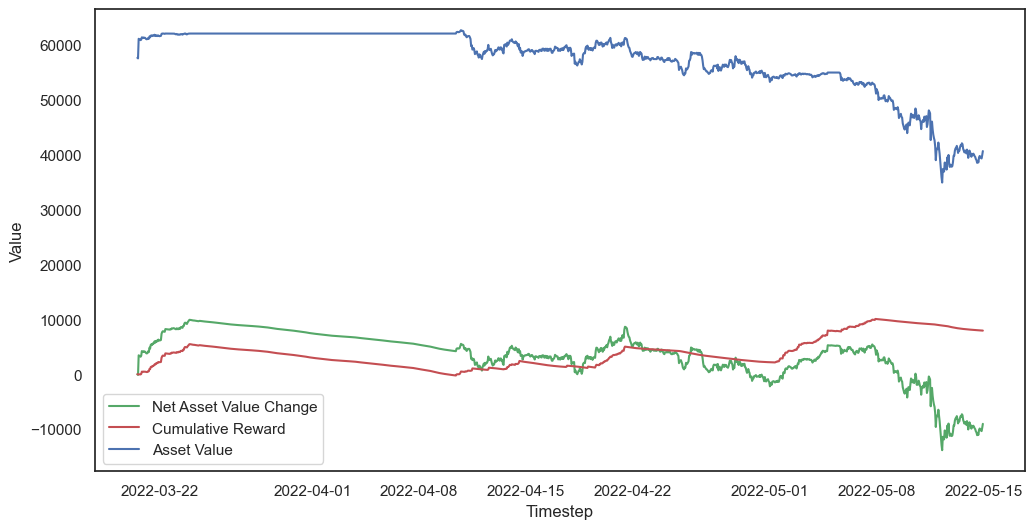

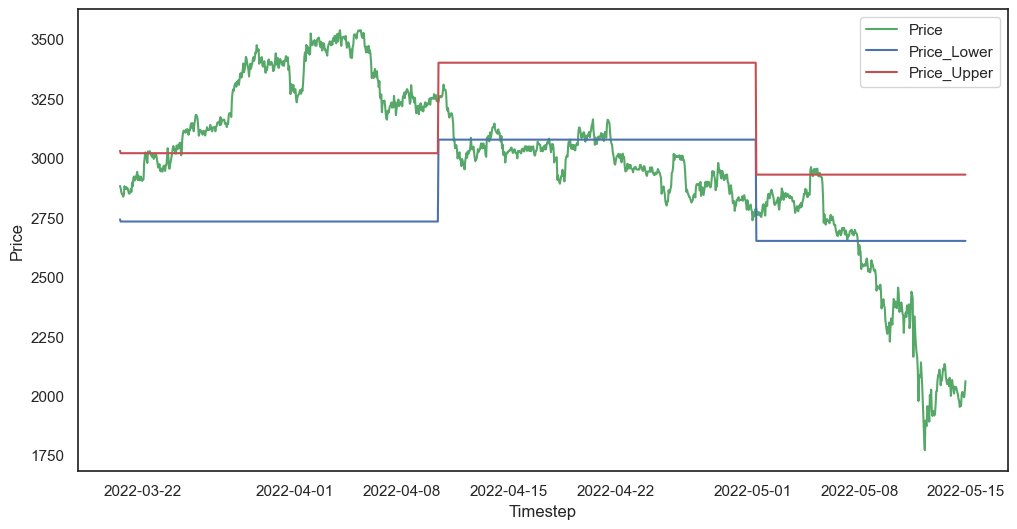

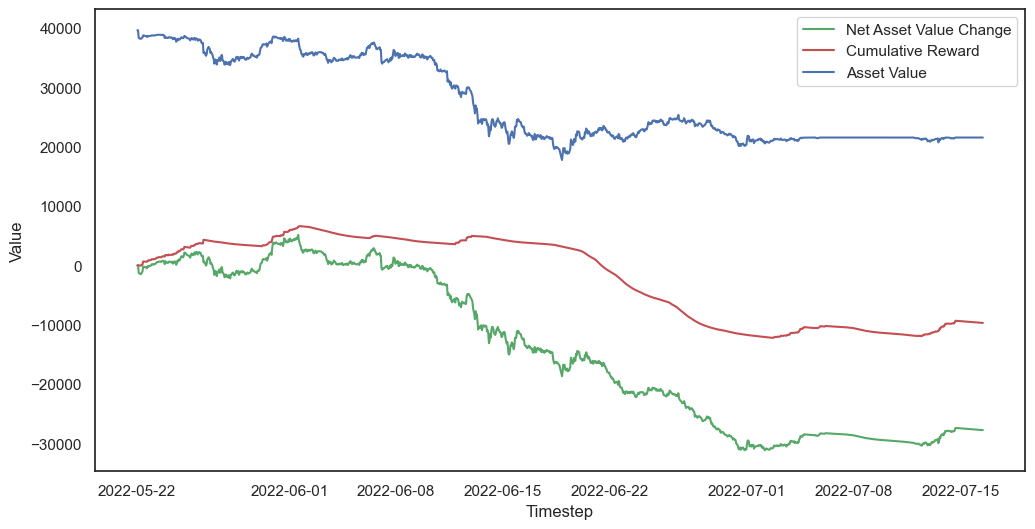

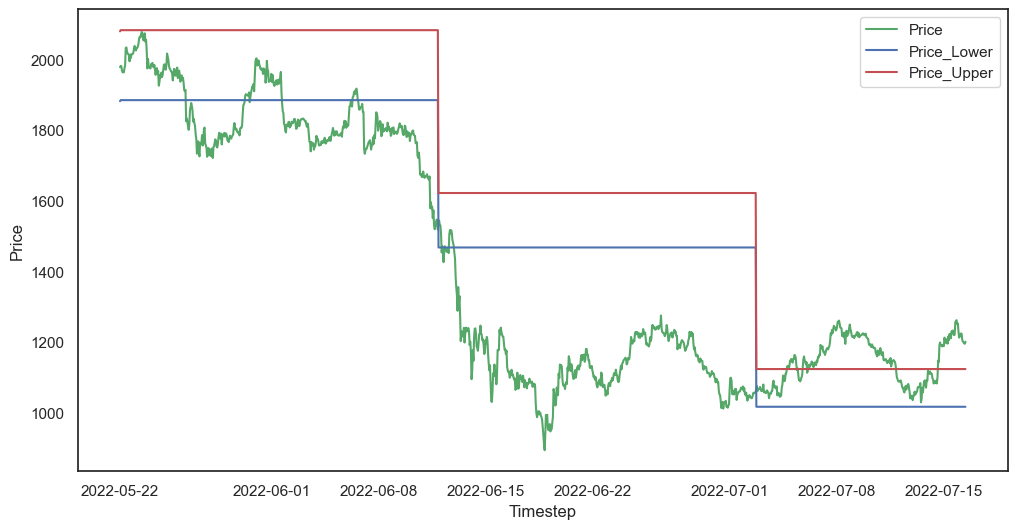

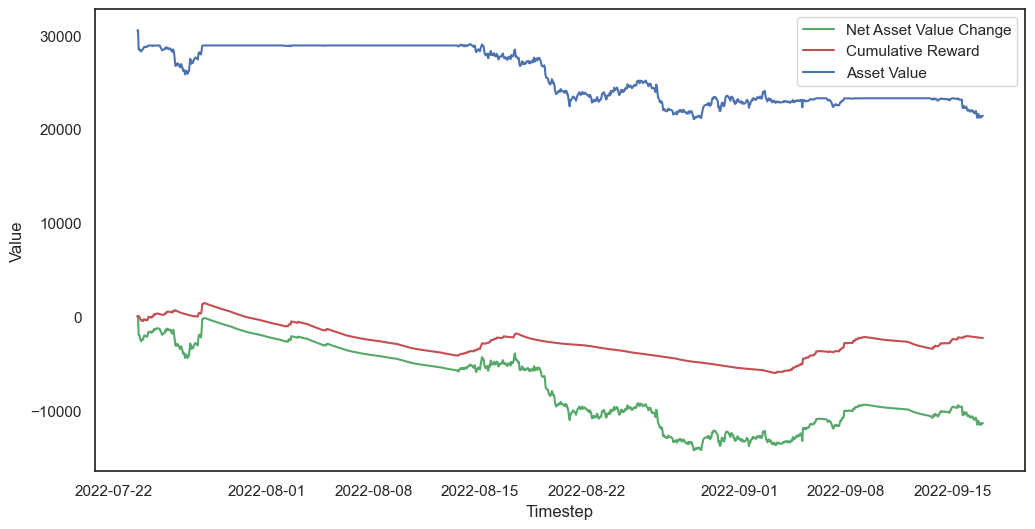

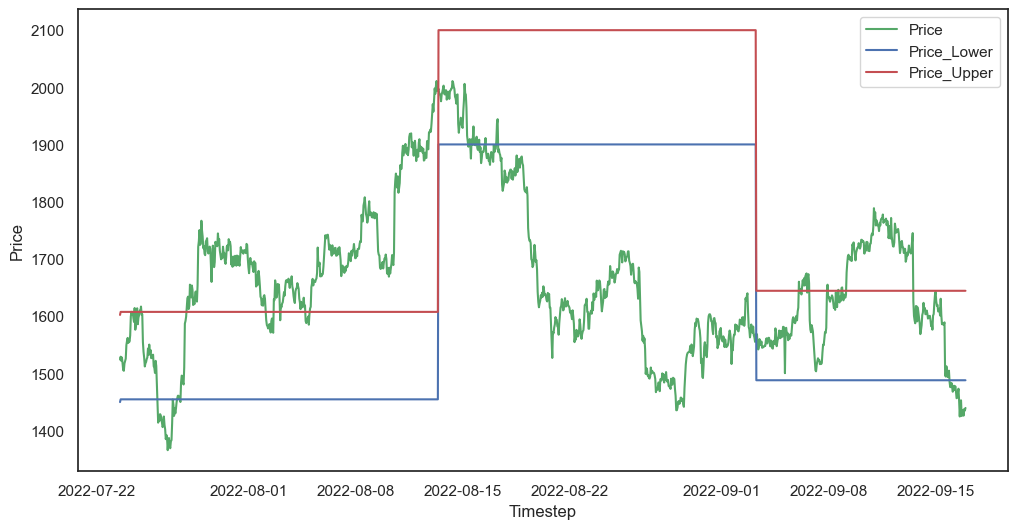

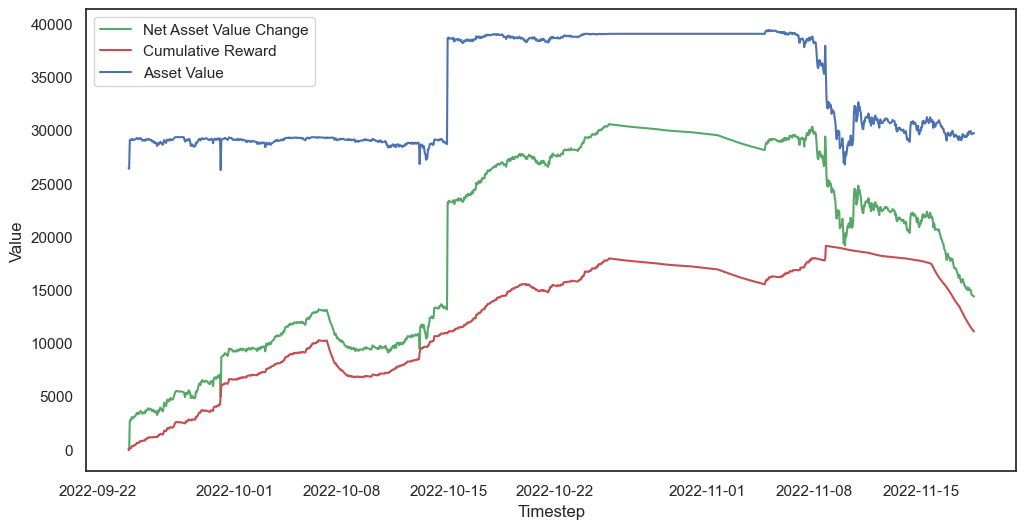

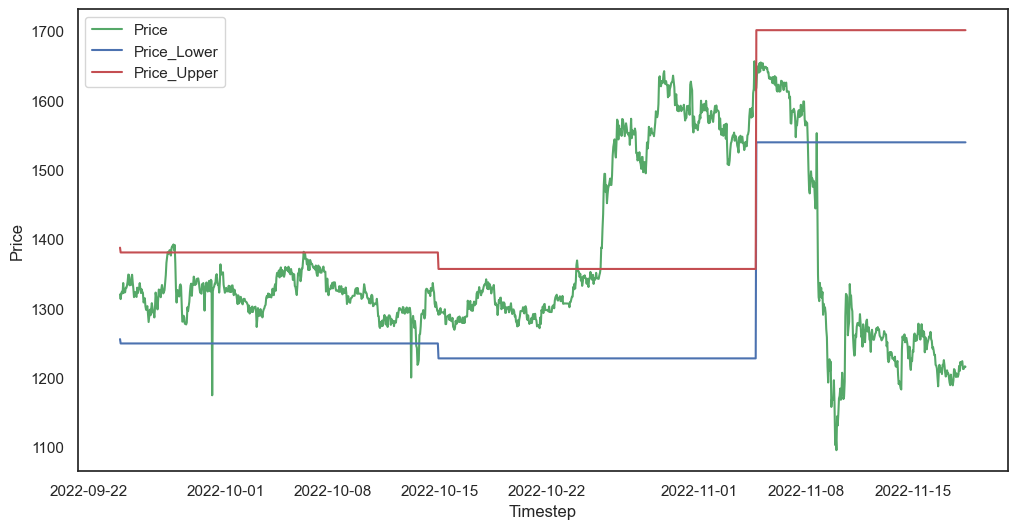

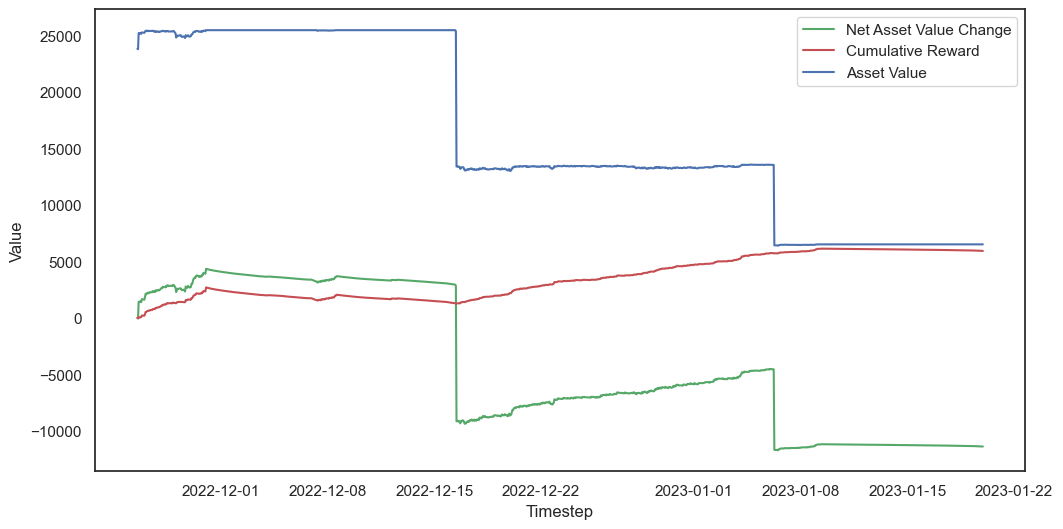

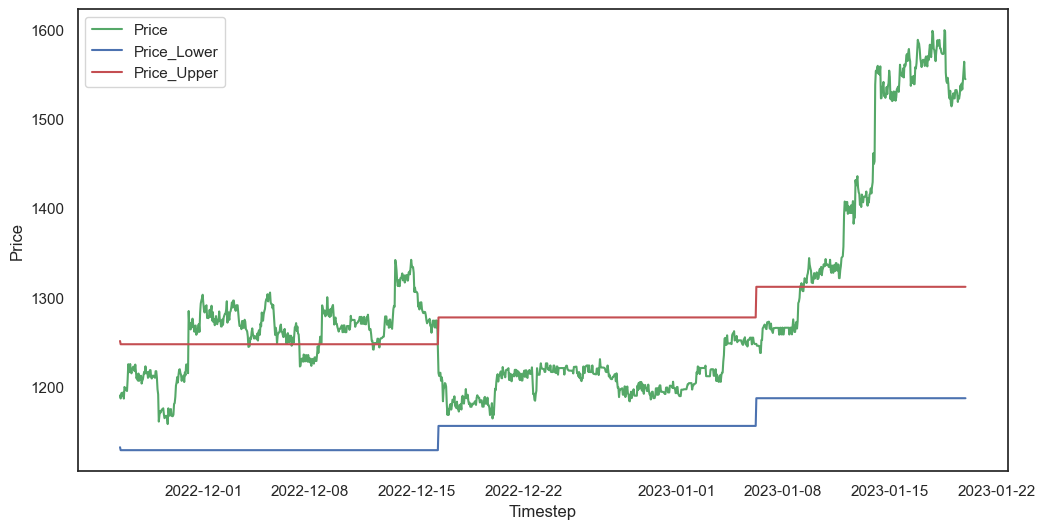

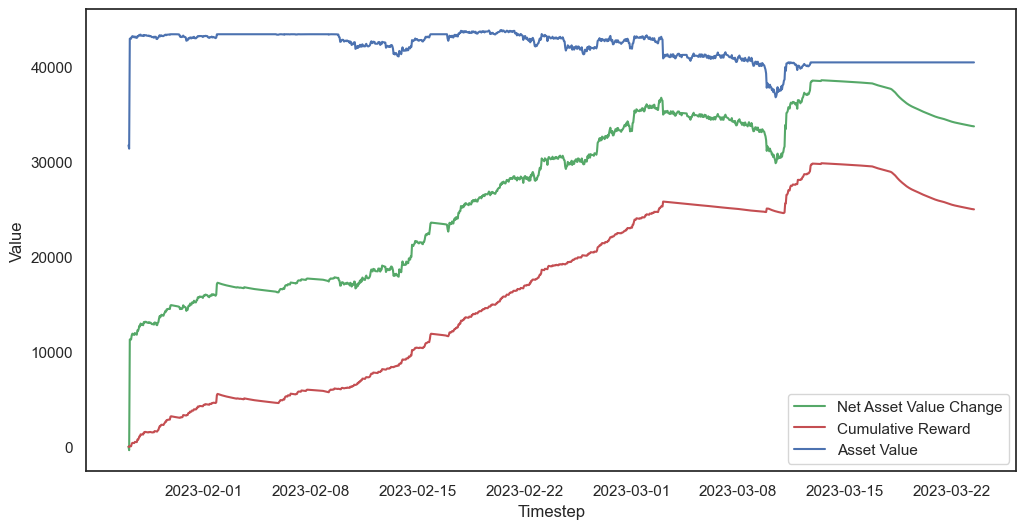

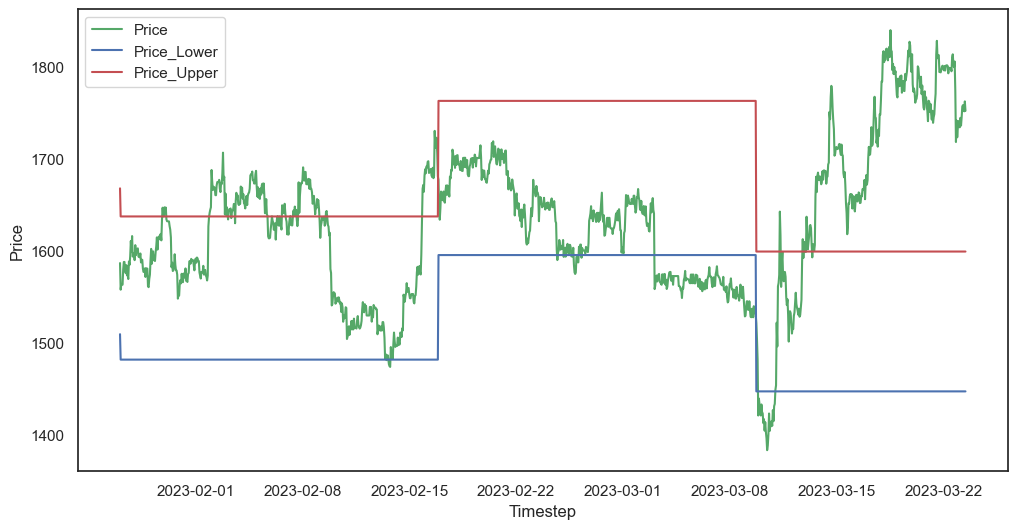

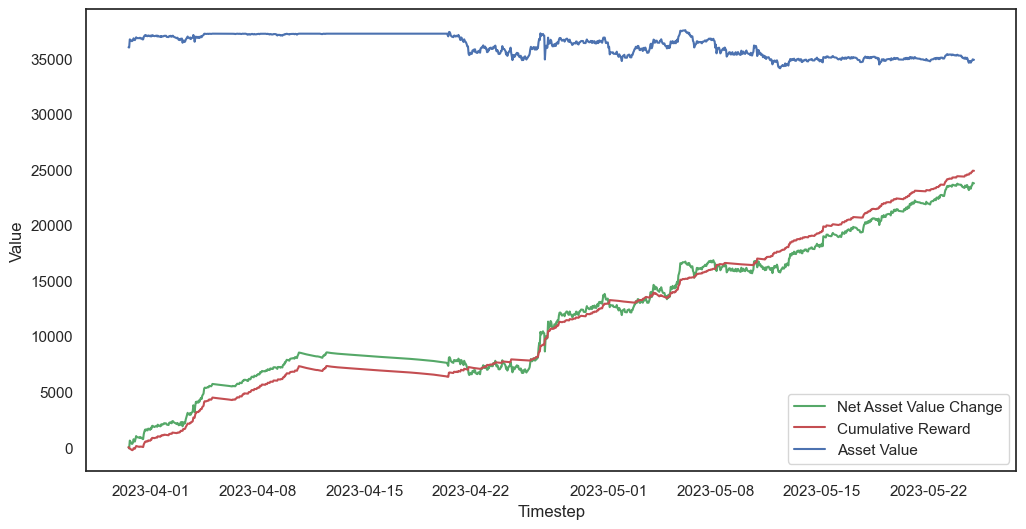

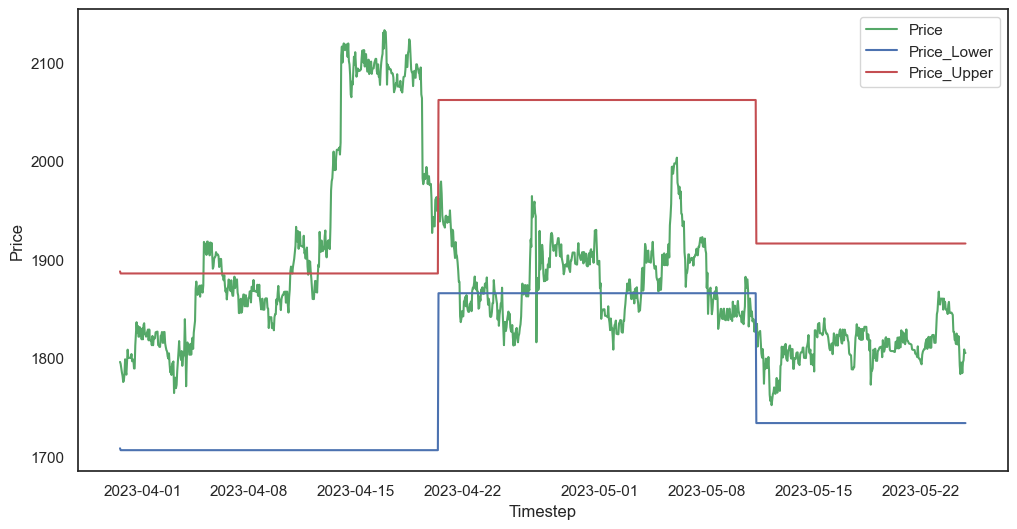

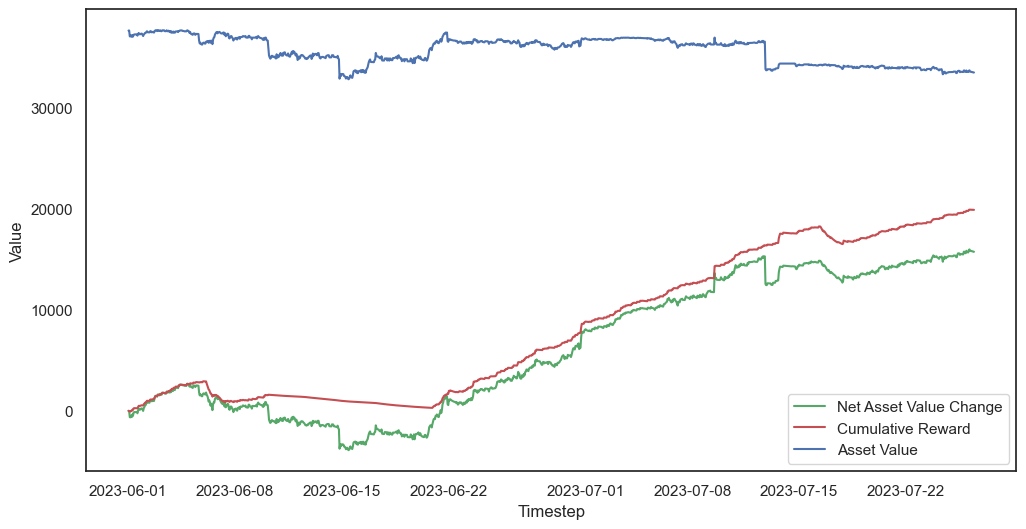

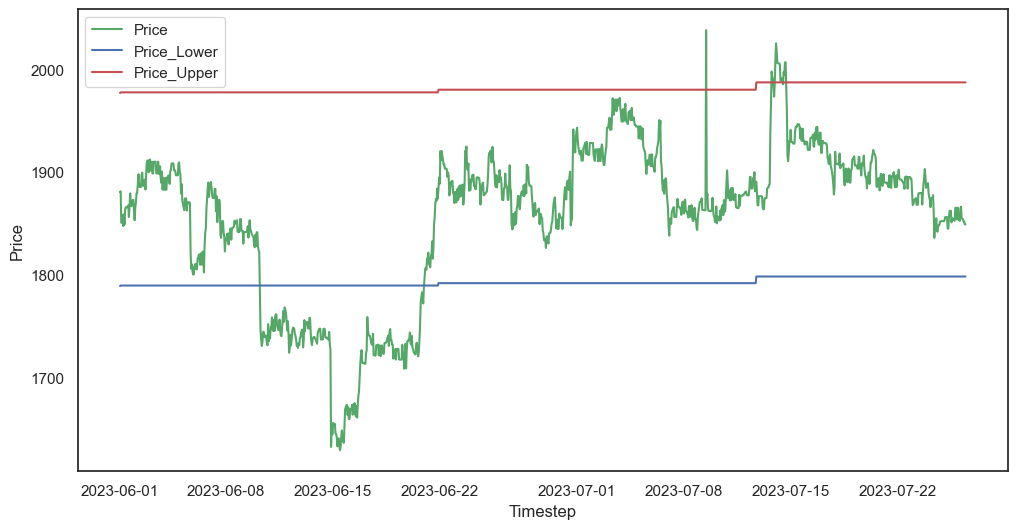

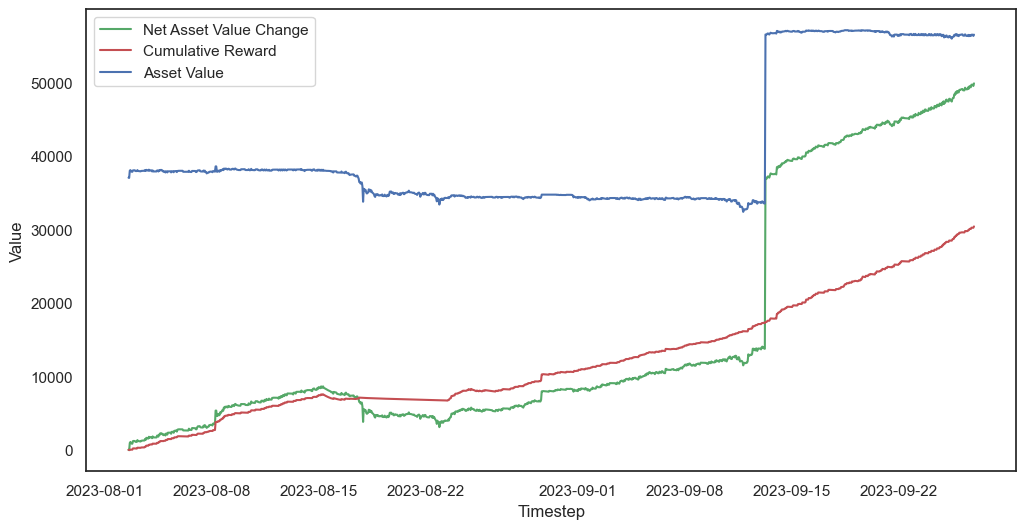

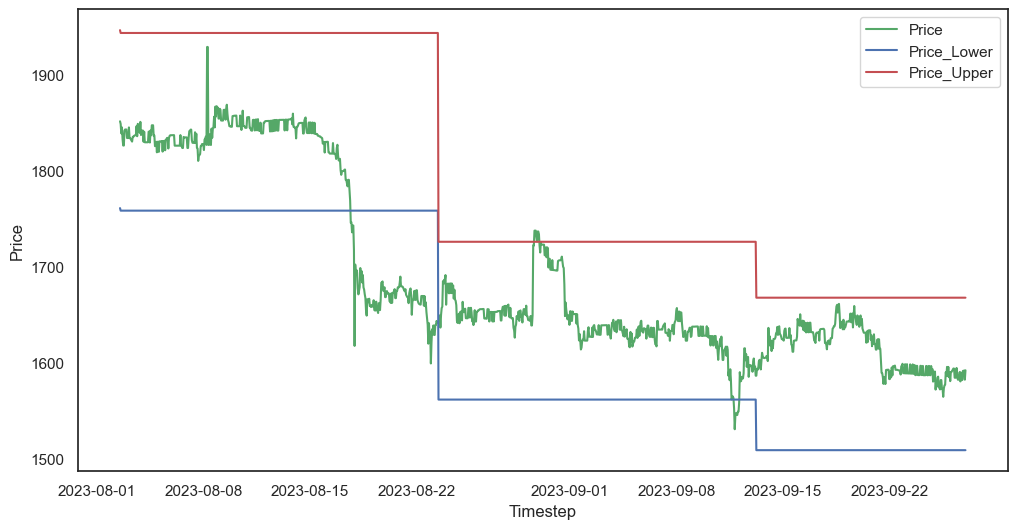

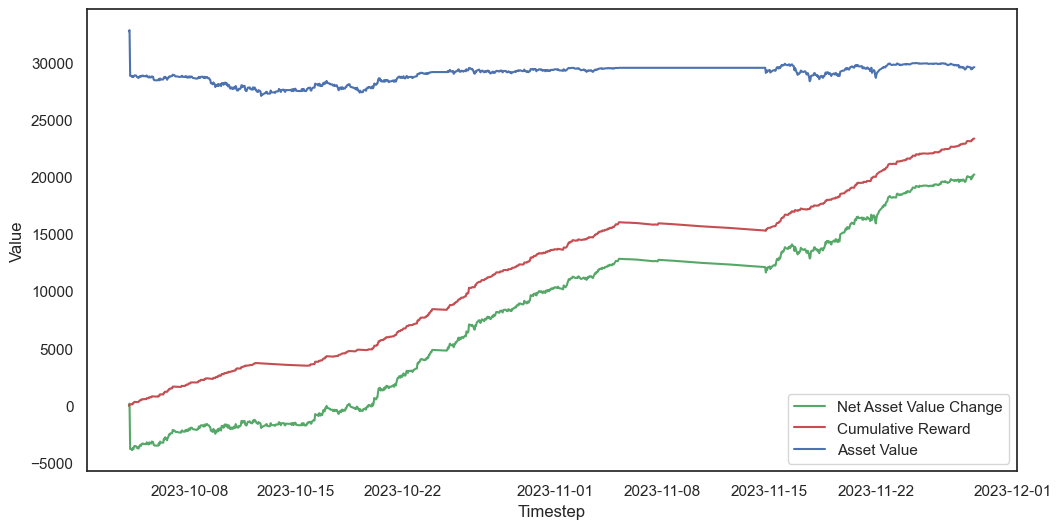

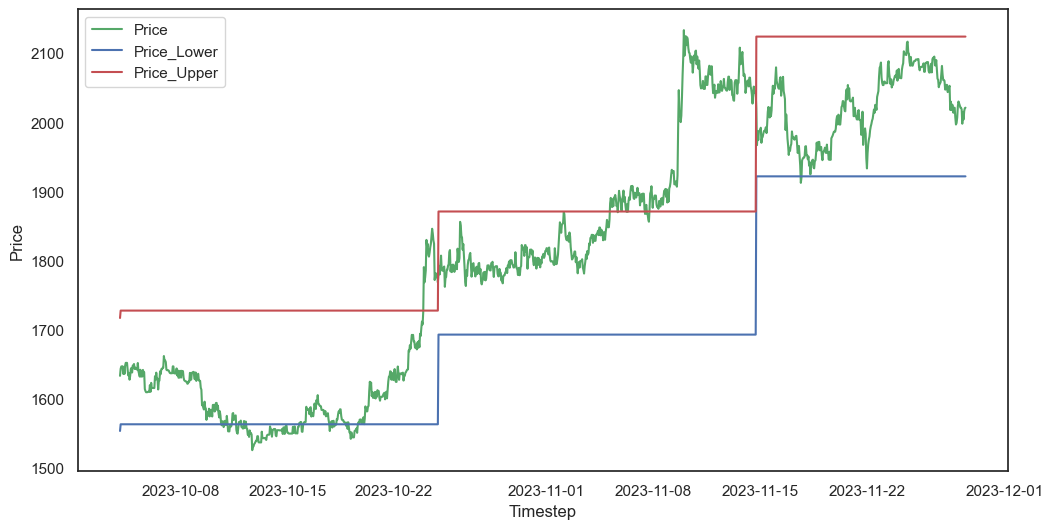

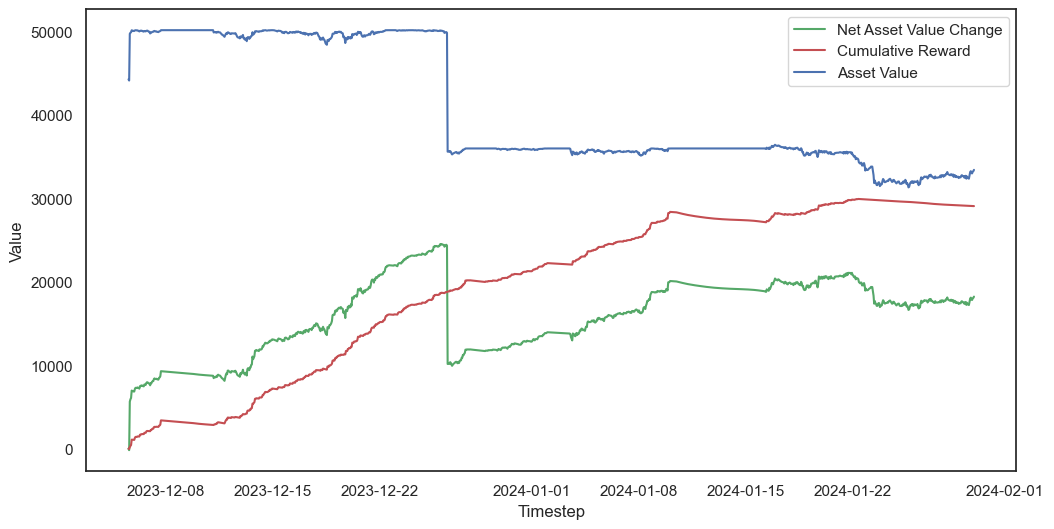

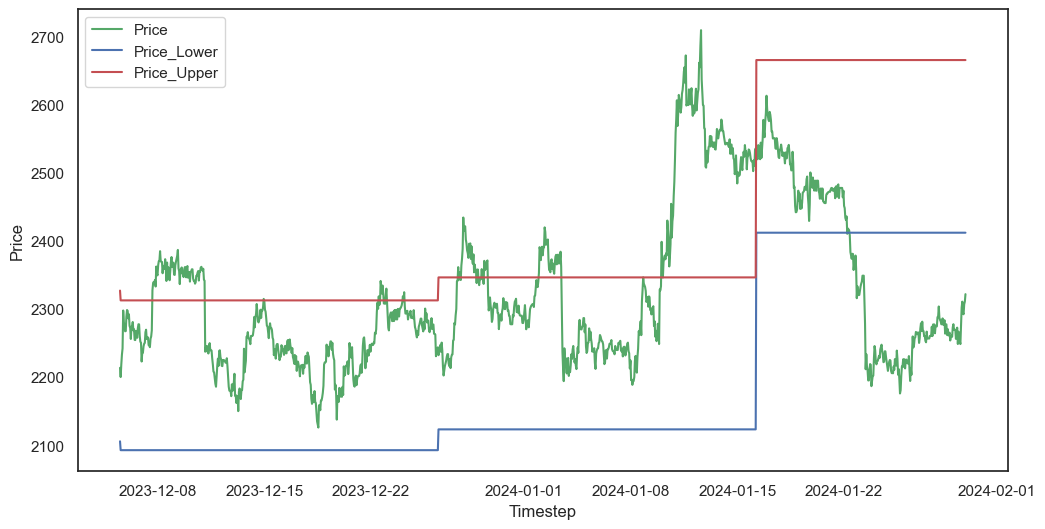

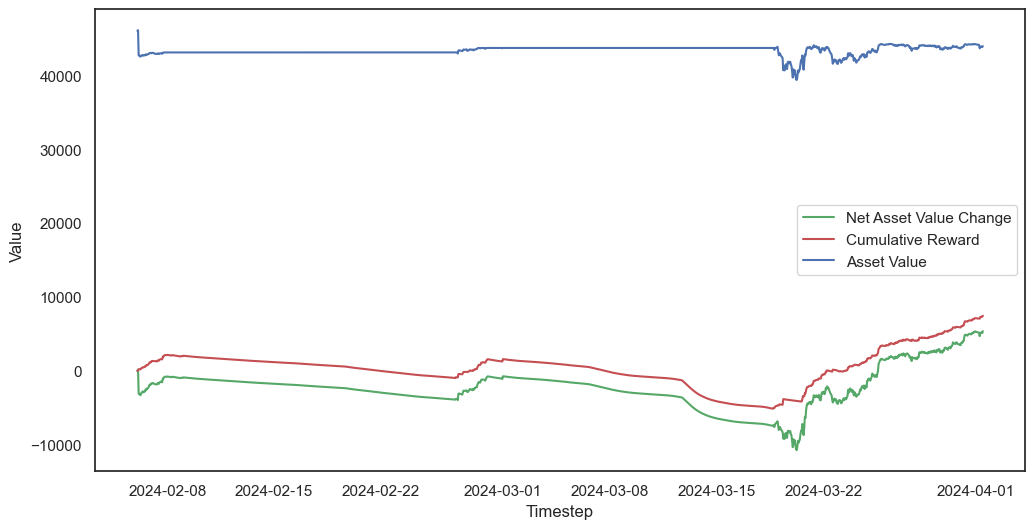

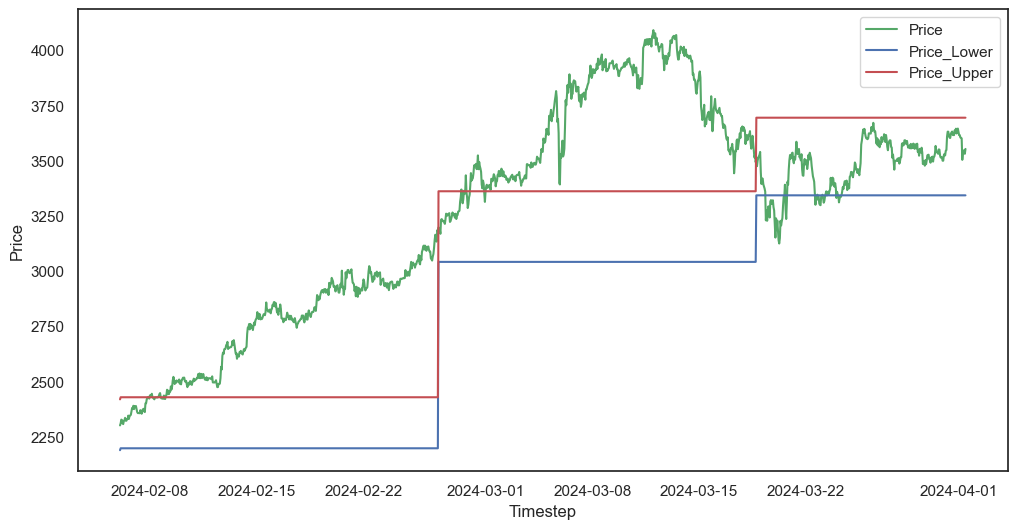

In [3]:
for i in range(len(dfs_list)-5):
    # plot the testing historical data
    
    def plot_values(df, name, times):
        plt.figure(figsize=(12, 8))

        x_history = df['X']
        y_history = df['Y']
        l_history = df['Liquidity']
        action_history = df['Action']

        plt.subplot(2, 2, 1)
        plt.plot(times, x_history, label='X values')
        plt.title('History of X Values')
        plt.xlabel('Timestep')
        plt.ylabel('X Value')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(times, y_history, label='Y values')
        plt.title('History of Y Values')
        plt.xlabel('Timestep')
        plt.ylabel('Y Value')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(times, l_history, label='Liquidity')
        plt.title('History of Liquidity')
        plt.xlabel('Timestep')
        plt.ylabel('Liquidity')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(times, action_history, label='Action')
        plt.title('History of Action')
        plt.xlabel('Timestep')
        plt.ylabel('Action')
        plt.legend()
        
        plt.tight_layout()
        
        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir) 
        filename = "plt_rw_{}_{}_value.png".format(i, name)
        file_path = os.path.join(output_dir, filename)
        
        plt.savefig(file_path, format='png')

    def plot_reward(df, name, times):
        reward_history = df['Reward']
        lvr_history = df['LVR']
        fee_history = df['Fee']

        plt.figure(figsize=(12, 6))
        plt.plot(times, fee_history, label='Fee', color='g')
        plt.plot(times, reward_history, label='Reward', color='b')
        plt.plot(times, lvr_history, label='LVR', color='r')

        plt.xlabel('Timestep')
        plt.ylabel('Value')
        plt.legend()
        
        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir) 
        filename = "plt_rw_{}_{}_reward.png".format(i, name)
        file_path = os.path.join(output_dir, filename)
        
        plt.savefig(file_path, format='png')
        
    def plot_cumulative(df, name, times):
        reward_history = df['Reward']
        cumum_reward = np.cumsum(reward_history)
        values = df['Value']
        plt.figure(figsize=(12, 6))

        plt.plot(times, cumum_reward + values - values[0], label='Net Asset Value Change', color='g')
        plt.plot(times, cumum_reward, label='Cumulative Reward', color='r')
        plt.plot(times, values, label='Asset Value', color='b')

        plt.xlabel('Timestep')
        plt.ylabel('Value')
        plt.legend()

        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir) 
        filename = "plt_rw_{}_benchmark_cumulative.png".format(i)
        file_path = os.path.join(output_dir, filename)
        
        plt.savefig(file_path, format='png')
    
    def plot_price(df, name, times):
        
        p_history = df['Price']
        pl_history = df['Price_Lower']
        pu_history = df['Price_Upper']

        plt.figure(figsize=(12, 6))
        plt.plot(times, p_history, label='Price', color='g')
        # dashed
        plt.plot(times, pl_history, label='Price_Lower', color='b')
        plt.plot(times, pu_history, label='Price_Upper', color='r')

        plt.xlabel('Timestep')
        plt.ylabel('Price')
        plt.legend()
        
        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir) 
        filename = "plt_rw_{}_benchmark_price.png".format(i)
        file_path = os.path.join(output_dir, filename)
        
        plt.savefig(file_path, format='png')
        
    def make_plots(df, name, time_test):
        time_test = time_test['timestamp']
        time_test = time_test[168:]
        time_test = time_test[:-1]
        time_test = pd.to_datetime(time_test)
        plot_cumulative(df, name, time_test)
        plot_price(df, name, time_test)


        
    # reward_history = df['Reward']
    # cumum_reward = np.cumsum(reward_history)
    # values = df['Value']
    
    # data_df = df[['Price', 'Price_Upper', 'Price_Lower', 'Value']]
    # data_df['Cumulative_Reward'] = cumum_reward
    # data_df['Net_Value_Change'] = cumum_reward + values - values[0]
    # combined_df = pd.concat([time_test, data_df], axis=0)
    
        
    print("ROLLING WINDOW:", i)
    df0 = dfs_list[i]
    df1 = dfs_list[i+1]
    df2 = dfs_list[i+2]
    df3 = dfs_list[i+3]
    df4 = dfs_list[i+4]
            
    uni_train = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)
    uni_test = dfs_list[i+5]
    
    time_train = pd.concat([times_list[i], times_list[i+1], times_list[i+2], times_list[i+3], times_list[i+4]], ignore_index=True)
    time_test = times_list[i+5]
    '''
    study 1: run action value 0 and 50, update every 500 timesteps
    '''
    name = '50_500'
    action_values = [0, 50]
    test_env = Uniswapv3Env(delta=params['delta'], action_values=action_values, 
                           market_data=uni_test, x=10, gas=gas_fee)
    test_env.reset()
    for j in range(len(uni_test) - 170):
        if j % 500 == 0:
            test_env.step(1)
        else:
            test_env.step(0)
            
    test_history = test_env.history
    df = pd.DataFrame(test_history)
    make_plots(df, name, time_test)
    
    # save to a .csv table under /data/ folder
    output_dir = os.path.join(data_dir, expname)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 
    filename = "test_history_bm_{}.csv".format(i)
    file_path = os.path.join(output_dir, filename)
    df.to_csv(file_path, index=False)
    
    # time_test = time_test['timestamp']
    time_test = time_test[168:]
    time_test = time_test[:-1]
    
    output_dir = os.path.join(data_dir, expname)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 
    filename = "timeline_{}.csv".format(i)
    file_path = os.path.join(output_dir, filename)
    time_test.to_csv(file_path, index=False)
    
    # print(df['Price'][0])

